<a href="https://colab.research.google.com/github/TheOtherBrian1/Blog_template/blob/main/Masterworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Masterworks</h1>
<a href = "https://drive.google.com/file/d/10Bsf0oopJYivXPt-q86EhULU3z2dIRzd/view?usp=sharing">Link</a> to problem set

<h4>Contents</h4>

<ul>
    <li>
        <a href = 'https://colab.research.google.com/drive/1JGVZZ8SXORBoF6ayguXmbuTLH9AalLIu?authuser=1#scrollTo=cea63916&line=1&uniqifier=1' target = '_self'>Part A </a>
        <ul>
            <li>
                <a href = 'https://colab.research.google.com/drive/1JGVZZ8SXORBoF6ayguXmbuTLH9AalLIu?authuser=1#scrollTo=cea63916&line=1&uniqifier=1'>1:</a> [Write both a Python and SQL script to create] a table where every row lists the number of investors and the total amount invested in each offering, further grouped by the state investors reside in.
            </li>
            <li>
                <a href = 'https://colab.research.google.com/drive/1JGVZZ8SXORBoF6ayguXmbuTLH9AalLIu?authuser=1#scrollTo=7162b80d&line=1&uniqifier=1'>2:</a> [Write both a Python and SQL script to create] two tables, based on the one above, shaped in a way that a value can be found by selecting a row and a column. <a href = 'https://colab.research.google.com/drive/1JGVZZ8SXORBoF6ayguXmbuTLH9AalLIu?authuser=1#scrollTo=d4d26815&line=1&uniqifier=1'>(Link to Conclusion)</a>
            </li>
        </ul>
    </li>
</ul>
<ul>
    <li>
        <a href = 'https://colab.research.google.com/drive/1JGVZZ8SXORBoF6ayguXmbuTLH9AalLIu?authuser=1#scrollTo=a57ddec1&line=1&uniqifier=1'>Part B </a>
        <ul>
            <li>
                <a href = 'https://colab.research.google.com/drive/1JGVZZ8SXORBoF6ayguXmbuTLH9AalLIu?authuser=1#scrollTo=a57ddec1&line=1&uniqifier=1'>1:</a> [Write an SQL script to create] a table whose entries reflect the total amount paid, relative to when its underlying orders were created, grouped by calendar month.
            </li>
            <li>
                <a href = 'https://colab.research.google.com/drive/1JGVZZ8SXORBoF6ayguXmbuTLH9AalLIu?authuser=1#scrollTo=a57ddec1&line=1&uniqifier=1'>2:</a> [Write a Python script to answer the following question:] what causes some payments to get paid later than others? Can we model thedifference between when an order was created and when it was paid?
            </li>
        </ul>
    </li> 
</ul>

<h4>Note:</h4>
    <ul>
        <li>
            All SQL was written for <a href = "https://www.postgresql.org/">PostgreSQL</a>
        </li>
        <li>
            The following libraries were used
        </li>
        <ul>
            <li>pandas</li>
            <li>psycopg2: used to create views and tables in PostgreSQL</li>
            <li>sqlalchemy: used to convert queried data into pandas dataframes</li>
            <li>seaborn: data visualization</li>
            <li>numpy: data formatting and helper funcitons</li>
            <li>matplot: data visualization</li>
            <li>scipy: T-testing</li>
        </ul>
    </ul>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#POSTGRESQL VARIABLES, SUBSTITUTE TO RUN ON YOUR OWN MACHINE

# user = 'INSERT USER HERE'
# database = 'masterworks'
# password = "INSERT PASSWORD HERE"
# host = '127.0.0.1'
# port = 'INSERT PORT HERE'

#The database is currently hosted on a free Heroku instance.
#The details are autogenerated and not associated with any compromisable accounts
#Although it's bad practice, I am not concerned with this specific instance getting compromised
#As it would cost me no money, and would not threaten any of my other accounts or projects
#The database works, but it is painfully slow, as it was not meant for heavy querying

# user = 'gymkabjmpaywgo'
# database = 'd26vr8kbje21i'
# password = "72fde30f495b5362f616241432bc4a374846cc439cf9c4d828f720d1826db045"
# host = 'ec2-54-204-128-96.compute-1.amazonaws.com'
# port = '5432'

<h4>Importing libraries</h4>

In [ ]:
import pandas as pd
import numpy as np
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import ttest_ind
warnings.filterwarnings('ignore')

<h4>Connecting to PostgreSQL</h4>

In [ ]:
connection = psycopg2.connect(
    user=user,
    database=database,
    password=password, 
    host=host, 
    port=port
)
connection.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
psycopg_cursor = connection.cursor()
print("PostgreSQL connected successfully")

PostgreSQL connected successfully


<h4>Creating a Masterworks database for storing views and tables</h4>

In [ ]:
#Create Masterworks Database if it does not exist

query = f"""
    --establish a secondary connection with the database
    
    --used to circumvent PostgreSQL limitation on creating databases from a remote connection
    --while checking to ensure the database does not already exist
    
    CREATE EXTENSION IF NOT EXISTS dblink;

    DO $$
        BEGIN
            PERFORM dblink_exec(
                'password = {password}
                 host={host}
                 user={user} 
                 port={port}', 
                 'CREATE DATABASE masterworks'
             );
            EXCEPTION 
                WHEN duplicate_database 
                THEN RAISE NOTICE '%, skipping', SQLERRM USING ERRCODE = SQLSTATE;
        END
    $$;
    
"""
try:
    psycopg_cursor.execute(query)
    print('Database masterworks created')
except:
    print('Database already exists')
psycopg_cursor.close()

Database masterworks created


<h4>Establishing a pandas compatible connection with PostgreSQL</h4>

In [ ]:
#Connect to mastworks database with SQLalchemy, which is compatible with pandas
engine = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{database}')
second_connection = engine.raw_connection()
alchemy_cursor = second_connection.cursor()
print(f'connected to {database} database')

connected to masterworks database


<h4>Converting provided CSVs into dataframes</h4>

In [ ]:
#Creating tables

path_to_orders = './mw_sample_data_orders.csv'
path_to_users = './mw_sample_data_users.csv'

orders_df = pd.read_csv(path_to_orders)
users_df = pd.read_csv(path_to_users)
try:
    orders_df.to_sql('orders', con=engine)
except:
    print('table orders already exists')

try:
    users_df.to_sql('users', con=engine)
except:
    print('table users already exists')

table orders already exists
table users already exists


In [ ]:
pd.set_option('display.max_rows', 12)

orders_df

,order_created_date,artwork,user,amount,paid_at_date,payment method
0,5/1/2021,Artwork A,User 18,5600,5/10/2021,wire
1,5/1/2021,Artwork A,User 11,600,5/11/2021,ACH
2,5/2/2021,Artwork A,User 53,810,5/6/2021,credit_card
3,5/3/2021,Artwork A,User 27,700,5/3/2021,credit_card
4,5/4/2021,Artwork A,User 52,5600,5/11/2021,wire
...,...,...,...,...,...,...
105,6/20/2021,Artwork C,User 34,200,6/29/2021,debit_card
106,6/27/2021,Artwork A,User 38,200,7/3/2021,wire
107,7/1/2021,Artwork C,User 16,1000,7/5/2021,wire
108,7/7/2021,Artwork C,User 42,5700,7/15/2021,ACH


In [ ]:
users_df

,user,age,collected_before,state
0,User 1,43,0,CA
1,User 2,37,0,CA
2,User 3,38,0,CA
3,User 4,38,1,CA
4,User 5,40,0,NY
...,...,...,...,...
49,User 69,49,0,CA
50,User 70,65,0,NY
51,User 72,49,0,TX
52,User 76,53,0,CA


<h1 id = 'partA'>PART A: Section 1</h1>

<h3 id = 'partA1'>1.</h3>
<p>
    [Write both a Python and SQL script to create] a table where every row lists the number of investors and the total amount invested in each offering, further grouped by the state investors reside in.
</p>

<h5>Table Requirements:</h5>
<ul>
    <li>Group the following</li>
    <ul>
        <li>Number of investors</li>
        <li>Total amount invested</li>
        <li>State investors are from</li>
    </ul>
 </ul>

<h6>Python Script</h6>

In [ ]:
orders_df
users_df
df = pd.merge(orders_df, users_df, on="user")
df = df[['state', 'artwork', 'amount', 'user']]
df = df.groupby(["state", "artwork"]).agg({"amount": [np.sum],'user' : [np.size]})
df = df.reset_index()
investors_per_work = df.rename(columns={"amount": "amount_invested", 'sum': '', "user": "total_investors", 'size':''})
investors_per_work

,state,artwork,amount_invested,total_investors
,,,,
0,AZ,Artwork A,4000,1
1,CA,Artwork A,55710,18
2,CA,Artwork B,64060,21
3,CA,Artwork C,77410,13
4,FL,Artwork B,3200,1
5,FL,Artwork C,300,1
6,NY,Artwork A,47230,15
7,NY,Artwork B,50860,17
8,NY,Artwork C,51410,15


<h6>SQL query</h6>

In [ ]:
query = """
    SELECT 
        state,
        artwork,
        SUM(amount) AS amount_invested,
        COUNT(users) AS total_investors
    FROM users
    INNER JOIN orders ON
        users.user = orders.user
    GROUP BY artwork, state
    ORDER BY state, artwork, amount_invested
"""

df = pd.read_sql_query(query, second_connection)
try:
    df.to_sql('investors_per_work', con=engine, if_exists='replace')
    print('table investors_per_work created')
except:
    print('investors_per_work could not be created')

df

table investors_per_work created


,state,artwork,amount_invested,total_investors
0,AZ,Artwork A,4000.0,1
1,CA,Artwork A,55710.0,18
2,CA,Artwork B,64060.0,21
3,CA,Artwork C,77410.0,13
4,FL,Artwork B,3200.0,1
5,FL,Artwork C,300.0,1
6,NY,Artwork A,47230.0,15
7,NY,Artwork B,50860.0,17
8,NY,Artwork C,51410.0,15
9,TX,Artwork A,1020.0,2


<h1 id = 'partA2'>Part A: Section 2</h1>
<p>
[Write both a Python and SQL script to create] two tables, based on the one above, shaped in a way that a value can be found by selecting a row and a column
</p>

<h5>Tables</h5>
    <ol>
        <li>
           Can be used to find the active investors, total investment, and average investment for each state
        </li>
        <li>
            Used to find the highest and lowest investements for each art piece
        </li>
    </ol>

<h6>Table1: Python script</h6>

In [ ]:
#Table 1: Investors per state and total invested
#investors_per_work['new'] = investors_per_work['amount_invested']
df = investors_per_work[['state', 'amount_invested','total_investors']]
df = df.groupby(["state"]).agg({'total_investors' : [np.sum], "amount_invested": [np.sum]})
df = df.reset_index()
df = df.rename(columns={'sum': '','total_investors': 'investors', 'new': 'avg_investment', 'average': ''})
df['avg_investment'] = df['amount_invested']//df['investors']
df.to_csv('Part_A_Python_Table_1.csv')

<h6>Table 1: SQL query</h6>

In [ ]:
#TABLE 1: Investors per state and total invested

query = """
    WITH temp AS (
        SELECT 
            state,
            SUM(total_investors) AS investors,
            SUM(amount_invested) AS total_invested
        FROM investors_per_work
        GROUP BY state
    )
    SELECT 
        state,
        investors,
        CAST(total_invested/investors AS INTEGER) AS avg_investment,
        CAST(total_invested AS INTEGER)
    FROM temp
    ORDER BY state
"""
df = pd.read_sql_query(query, second_connection)
df.to_csv('Part_A_SQL_Table_1.csv')
df

,state,investors,avg_investment,total_invested
0,AZ,1.0,4000,4000
1,CA,52.0,3792,197180
2,FL,2.0,1750,3500
3,NY,47.0,3181,149500
4,TX,7.0,681,4770


<h3>PART A2: Table 1 Extra Credit</h3>
<p>My reasoning behind choosing the above variables is because they answer basic business questions that are essential for growth. The amount of investors per state allows one to consider whether they should prioritize receptive markets or allocate resources towards tapping into large, yet difficult markets. It raises important questions, such as "why are some market more receptive?" and "how much potential do these markets have?"</p>

<p>
    "avg_investment" and "total_invested" can help answer and direct the questions that naturally arise when contemplating expansion. These variables also lend themselves nicely towards visualization, which is the corner stone of data driven story telling. Creating a narrative that outlines the path towards success is essential, so whenever I see data that clearly denotes a story direction, especially when that story is easy to visualize, it should be told
</p>

<h6>Table 1: Visuals</h6>

Text(0.5, 1.0, 'Total Investors by State')

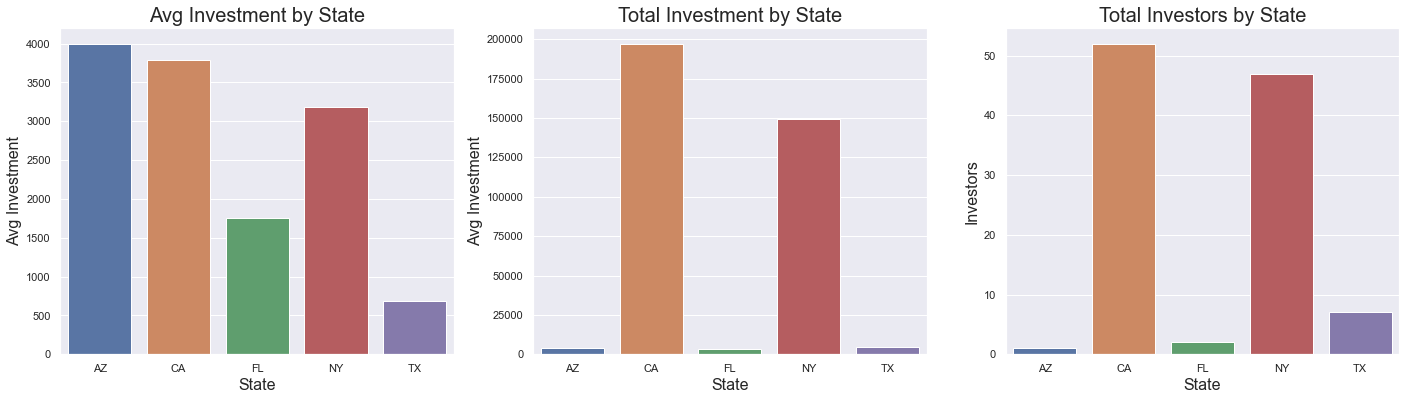

In [ ]:
#Seaborn Visual
sns.set(rc = {'figure.figsize':(24,6)})
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False)


first = plot = sns.barplot(data=df, x="state", y="avg_investment", ax=ax1)
plot.set_xlabel("State", fontsize = 16)
plot.set_ylabel("Avg Investment", fontsize = 16)
plot.set_title('Avg Investment by State', fontsize = 20)

second = plot = sns.barplot(data=df, x="state", y="total_invested", ax=ax2)
plot.set_xlabel("State", fontsize = 16)
plot.set_ylabel("Avg Investment", fontsize = 16)
plot.set_title('Total Investment by State', fontsize = 20)

third = plot = sns.barplot(data=df, x="state", y="investors", ax=ax3)
plot.set_xlabel("State", fontsize = 16)
plot.set_ylabel("Investors", fontsize = 16)
plot.set_title('Total Investors by State', fontsize = 20)


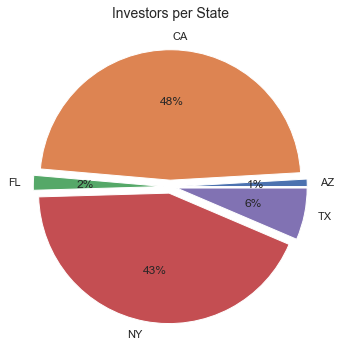

In [ ]:
plt.pie(data= df, labels='state',x= 'investors',explode=[0.05]*5, autopct='%.0f%%')
plt.title("Investors per State", fontsize=14);
plt.show()

<h6>Table 2: Python script</h6>

In [ ]:
#TABLE 2: maximum and minimum invested by investors for each piece
max_df = investors_per_work[['amount_invested','state','artwork']]
max_df = max_df.groupby(['artwork', 'amount_invested']).max()
max_df = max_df.reset_index().groupby('artwork').last()
max_df.reset_index()

min_df = investors_per_work[['amount_invested','state','artwork']]
min_df = min_df.groupby(['artwork', 'amount_invested']).min()
min_df = min_df.reset_index().groupby('artwork').first()
min_df.reset_index()

df = pd.merge(max_df, min_df, on="artwork")
df = df.rename(columns={"amount_invested_x": "max_invested", 'amount_invested_y': 'min_invested', "state_x": "max_state", 'state_y':'min_state'})
df['difference'] = df['max_invested'] - df['min_invested']
df['multiples_larger'] = df['max_invested']/df['min_invested']
df.reset_index()
df.to_csv('Part_A_Python_Table_2.csv')

<h6>Table 2: SQL query</h6>

In [ ]:
#TABLE 2: maximum and minimum invested by investors for each piece

query = """
    WITH max_min_values AS(
    
        --Finding min and max value
        
        SELECT
            state,
            artwork,
            MAX(amount_invested),
            MIN(amount_invested)
        FROM investors_per_work
        GROUP BY artwork, state
    ),
    max_rank AS (
        -- ranking and ordering the states by 
    
        SELECT 
            state,
            artwork,
            max,
            RANK() OVER (PARTITION BY artwork ORDER BY max DESC) AS max_rank
        FROM max_min_values
    ),
    min_rank AS (
        SELECT
            state,
            artwork,
            min,
            RANK() OVER (PARTITION BY artwork ORDER BY min ASC) AS min_rank
        FROM max_min_values
    )
    SELECT
        max_rank.artwork,
        max_rank.state AS max_state,
        max AS max_invested,
        min_rank.state AS min_state,
        min AS min_invested,
        max - min AS difference,
        ROUND(CAST(max/min AS NUMERIC), 2) AS multiples_larger
    FROM max_rank
    INNER JOIN min_rank ON
        max_rank.artwork = min_rank.artwork
    WHERE 
        max_rank = 1
            AND
        min_rank = 1
"""
df = pd.read_sql_query(query, second_connection)
df.to_csv('Part_A_SQL_Table_2.csv')
df

,artwork,max_state,max_invested,min_state,min_invested,difference,multiples_larger
0,Artwork A,CA,55710.0,TX,1020.0,54690.0,54.62
1,Artwork B,CA,64060.0,FL,3200.0,60860.0,20.02
2,Artwork C,CA,77410.0,FL,300.0,77110.0,258.03


<h3>PART A2: Table 2 Extra Credit</h3>
<p>
    Extremes and outliers are often overlooked, but, by definition, they do define what's the best and worst scenario. What stands out to me is that California attracts generous investments. Who are these investors and is there a way to direct our marketing efforts to capture people who share in their investing philosophy? Who are the investors who still invest, yet comparitively modestly? How many are there? What age are they? Do they over time become more willing to engage?
</p>
<p>
    A question is only as important as the gravity of its answer and the questions the data inspires has gravity. Though limited, this max/min table can offer insights into capturing more lucrative customers, while fostering the participation of young or reluctant investors.
 </p

<h1>PART B: Section 1</h1>

<h3>1.</h3>
<p>
[Write an SQL script to create] a table whose entries reflect the total amount paid, relative to when its underlying orders were created, grouped by calendar month.
</p>

<h5>Table Requirements:</h5>
<ul>
    <li>Group the following</li>
    <ul>
        <li>Calendar month</li>
        <li>Amount invested</li>
    </ul>
 </ul>

In [ ]:
query = """
    SELECT
        DATE_TRUNC('month', CAST(order_created_date AS TIMESTAMP)) AS date,
        SUM(CAST(amount AS MONEY))
    FROM orders
    GROUP BY date
    ORDER BY date
"""
df = pd.read_sql_query(query, second_connection)
df.to_csv('Part_B_SQL_Table_1_First_Interpretation.csv')
df

,date,sum
0,2021-05-01,"$208,250.00"
1,2021-06-01,"$138,300.00"
2,2021-07-01,"$14,400.00"


In [ ]:
query = """
    WITH daily_sum AS (
        SELECT
            TO_CHAR(CAST(order_created_date AS TIMESTAMP), 'Month') AS month,
            CAST(order_created_date AS DATE) AS date,
            SUM(CAST(amount AS MONEY)) AS daily_sum
        FROM orders
        GROUP BY TO_CHAR(CAST(order_created_date AS TIMESTAMP), 'Month'), date
    )
    SELECT
        month,
        date,
        daily_sum,
        SUM(daily_sum) OVER (PARTITION BY month ORDER BY date) AS running_total
    FROM daily_sum
    ORDER BY date
"""
df = pd.read_sql_query(query, second_connection)
df.to_csv('Part_B_SQL_Table_1_Second_Interpretation.csv')
df


,month,date,daily_sum,running_total
0,May,2021-05-01,"$6,200.00","$6,200.00"
1,May,2021-05-02,$810.00,"$7,010.00"
2,May,2021-05-03,$700.00,"$7,710.00"
3,May,2021-05-04,"$5,600.00","$13,310.00"
4,May,2021-05-05,"$1,350.00","$14,660.00"
...,...,...,...,...
42,June,2021-06-20,$200.00,"$138,100.00"
43,June,2021-06-27,$200.00,"$138,300.00"
44,July,2021-07-01,"$1,000.00","$1,000.00"
45,July,2021-07-07,"$5,700.00","$6,700.00"


<h1>Part B: Section 2</h1>
<p>
[Write a Python script to answer the following question:] what causes some payments to get paid later than others? Can we model the difference between when an order was created and when it was paid? 
</p>

<h5>Plan of action:</h5>
<ul>
    <li>Explore data and Create visuals</li>
    <li>Come up with a hypothesis</li>
    <li>Test hypothesis</li>
 </ul>

<h3>Exploring Data</h3>

In [ ]:
#Connecting to self-hosted PostgreSQL database with psycopg2
#Used to create views, which sqlAlchemy cannot do with ease
connection = psycopg2.connect(
    user=user, 
    database=database,
    password=password, 
    host=host, 
    port=port
)
connection.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
psycopg_cursor = connection.cursor()
print("PostgreSQL connected successfully")

PostgreSQL connected successfully


In [ ]:
#Finding the time between order initialization and payment based on payment method

query = """
    CREATE VIEW payment_between AS
        SELECT
            order_created_date,
            paid_at_date,
            CAST(paid_at_date AS DATE) - CAST(order_created_date AS DATE) AS time_between_payment,
            "payment method"
        FROM orders
        ORDER BY "payment method";

"""
try:
    psycopg_cursor.execute(query)
    print('view created')
except:
    print('view already exist')
#psycopg_cursor.close()

view already exist


In [ ]:
#A general table to see how variables affect time_between payments
query = """
    SELECT 
        orders.user,
        artwork,
        CAST(paid_at_date AS DATE) - CAST(order_created_date AS DATE) AS time_between_payment,
        "payment method",
        CAST(amount AS NUMERIC),
        collected_before,
        state
        
    FROM users
    INNER JOIN orders ON
        users.user = orders.user
    ORDER BY
        state, "payment method", time_between_payment
"""

df = pd.read_sql_query(query, second_connection)
df

,user,artwork,time_between_payment,payment method,amount,collected_before,state
0,User 68,Artwork A,8,ACH,4000.0,0,AZ
1,User 44,Artwork B,0,ACH,6300.0,0,CA
2,User 61,Artwork B,1,ACH,600.0,0,CA
3,User 48,Artwork B,1,ACH,7300.0,0,CA
4,User 22,Artwork B,1,ACH,1400.0,0,CA
...,...,...,...,...,...,...,...
104,User 39,Artwork C,7,credit_card,340.0,0,TX
105,User 13,Artwork A,3,debit_card,920.0,1,TX
106,User 39,Artwork A,7,wire,100.0,0,TX
107,User 39,Artwork C,8,wire,1000.0,0,TX


<h5>Visualizing any patterns between amount and payment time</h5>

<AxesSubplot:xlabel='amount', ylabel='time_between_payment'>

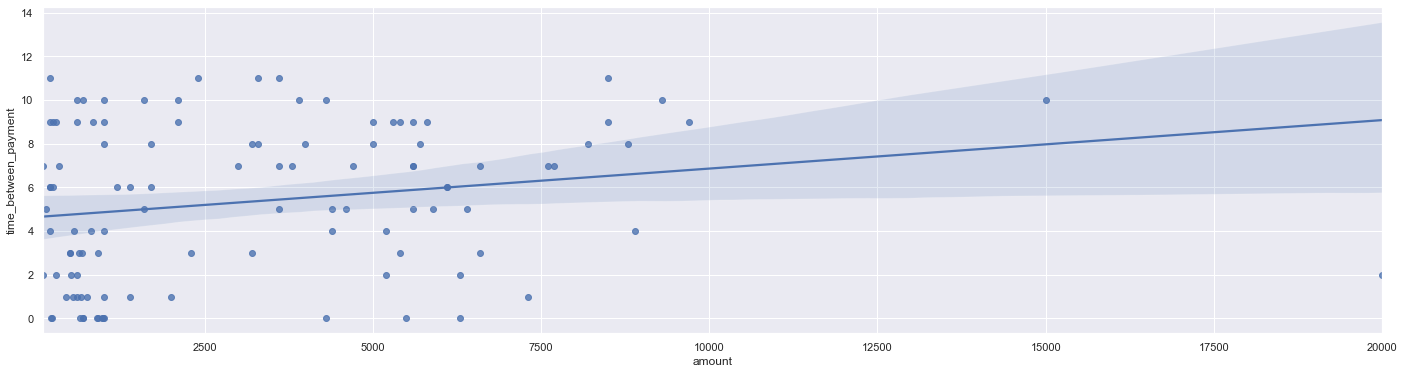

In [ ]:
sns.regplot(data=df, x="amount", y="time_between_payment")

In [ ]:
#Informtation mapping state frequency and other factors to payment time
query = """
    SELECT 
        AVG(CAST(paid_at_date AS DATE) - CAST(order_created_date AS DATE)) AS avg_time_between_payment,
        COUNT(user),
        STDDEV(CAST(paid_at_date AS DATE) - CAST(order_created_date AS DATE)),
        "payment method",
        state
    FROM users
    INNER JOIN orders ON
        users.user = orders.user
        WHERE 
        state NOT LIKE 'AZ' 
            AND 
        state NOT LIKE 'FL'
    GROUP BY 
        state, "payment method"
    ORDER BY
        "payment method"
"""

df = pd.read_sql_query(query, second_connection)
df

,avg_time_between_payment,count,stddev,payment method,state
0,5.250000,20,3.290737,ACH,CA
1,6.400000,10,3.949684,ACH,NY
2,1.250000,8,1.581139,credit_card,CA
3,3.000000,3,3.605551,credit_card,TX
4,3.166667,6,3.371449,credit_card,NY
5,3.000000,1,NaN,debit_card,TX
6,0.000000,3,0.000000,debit_card,CA
7,3.166667,6,3.188521,debit_card,NY
8,8.333333,3,1.527525,wire,TX
9,6.047619,21,2.539216,wire,CA


<p>Visualizing relationship between average payment finalization and state</p>


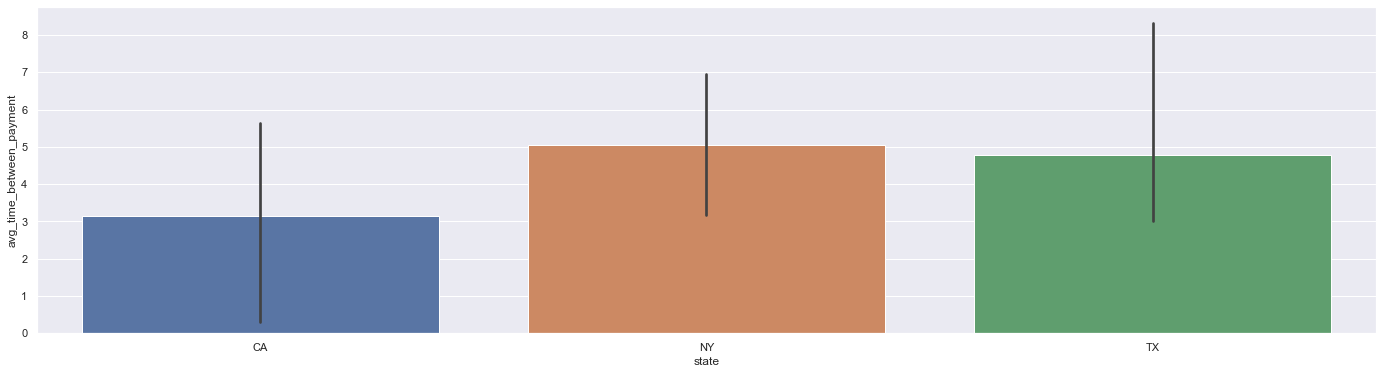

In [ ]:
plot = sns.barplot(data=df, x="state", y="avg_time_between_payment")

In [ ]:
query = """
    SELECT * FROM payment_between
    ORDER BY time_between_payment
"""

df = pd.read_sql_query(query, second_connection)
df

<AxesSubplot:xlabel='payment method', ylabel='time_between_payment'>

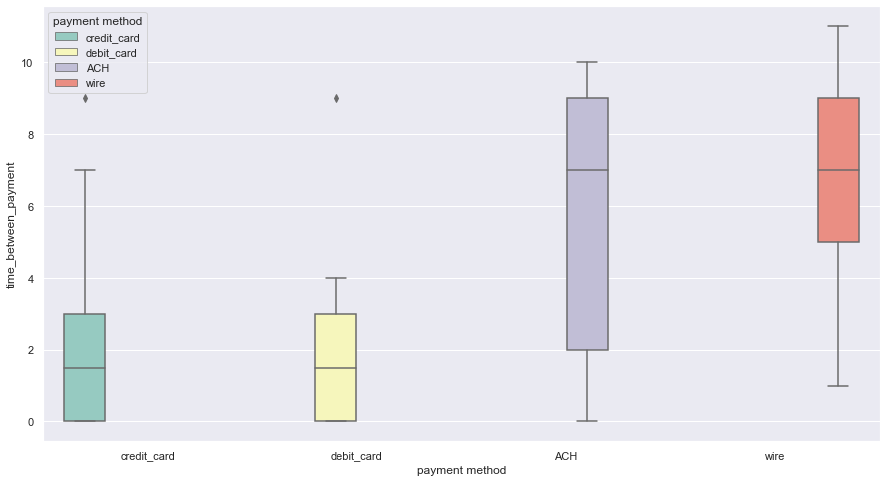

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.boxplot(x="payment method", y="time_between_payment", hue="payment method", data=df, palette="Set3")

In [ ]:
#Creating view that contains variables associated with both state and payment finalization
query = """
    CREATE VIEW state_time_between AS
        SELECT 
            state,
            "payment method",
            CAST(paid_at_date AS DATE) - CAST(order_created_date AS DATE) AS time_between_payment
        FROM orders
        INNER JOIN users ON
            users.user = orders.user
        ORDER BY state, "payment method", time_between_payment
"""

try:
    psycopg_cursor.execute(query)
    print('view created')
except:
    print('view already exist')


view already exist


In [ ]:
query = """
    SELECT 
        *
    FROM state_time_between
    WHERE state LIKE 'CA'
"""
ca = pd.read_sql_query(query, second_connection)

query = """
    SELECT 
        *
    FROM state_time_between
    WHERE state LIKE 'NY'
"""
ny = pd.read_sql_query(query, second_connection)

Text(0.5, 1.0, 'California Payment Delay')

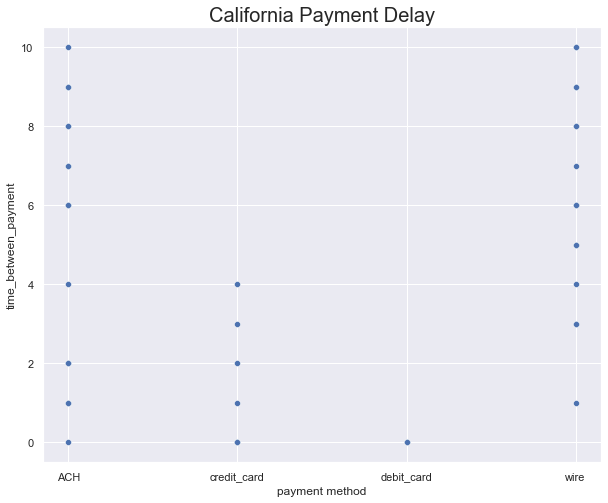

In [ ]:
sns.set(rc = {'figure.figsize':(10,8)})
plot = sns.scatterplot(data=ca, x="payment method", y="time_between_payment")
plot.set_title('California Payment Delay', fontsize = 20)

Text(0.5, 1.0, 'New York Payment Delay')

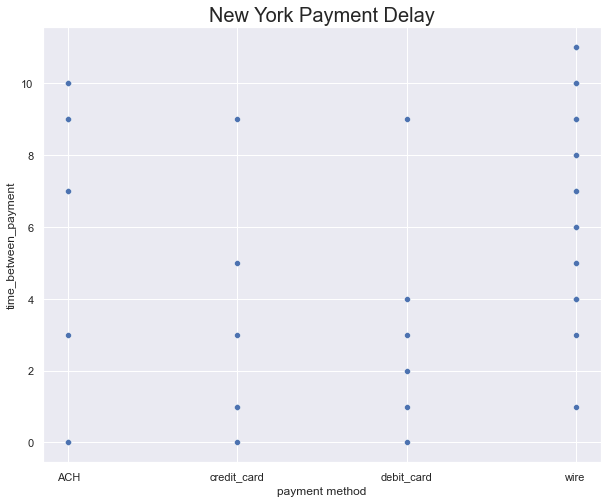

In [ ]:
plot = sns.scatterplot(data=ny, x="payment method", y="time_between_payment")
plot.set_title('New York Payment Delay', fontsize = 20)

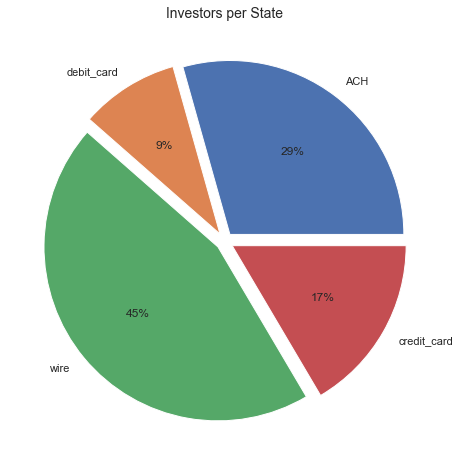

In [ ]:
query = """
    SELECT 
        COUNT("payment method"),
        "payment method"
    FROM state_time_between
    GROUP BY "payment method"
"""
df = pd.read_sql_query(query, second_connection)
df
plt.pie(data= df, x = 'count', labels = "payment method", explode=[0.05]*4, autopct='%.0f%%')
plt.title("Investors per State", fontsize=14);
plt.show()

In [ ]:
query = """
    SELECT 
        time_between_payment,
        "payment method"
    FROM state_time_between
"""
df = pd.read_sql_query(query, second_connection)
df

,time_between_payment,payment method
0,8,ACH
1,0,ACH
2,1,ACH
3,1,ACH
4,1,ACH
...,...,...
104,7,credit_card
105,3,debit_card
106,7,wire
107,8,wire


Text(0.5, 0, 'debit')

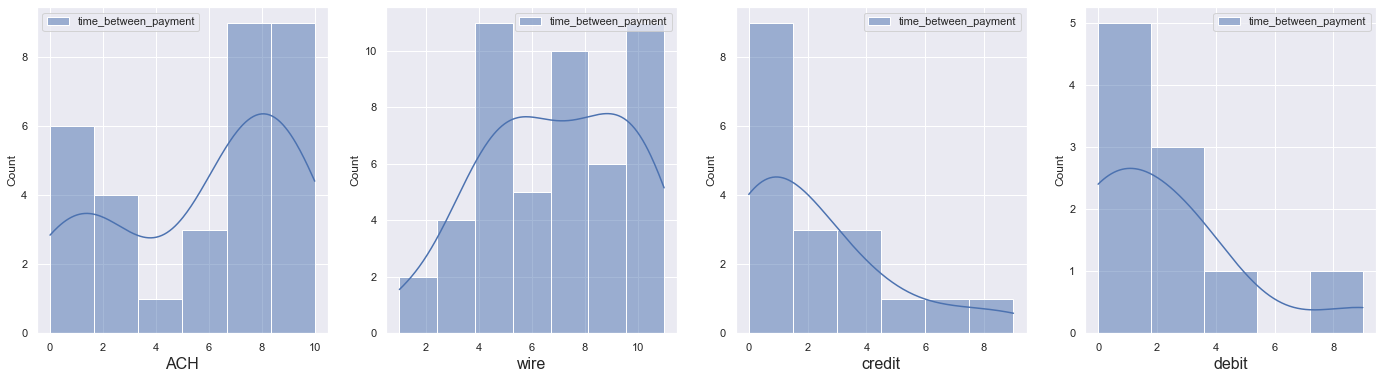

In [ ]:
#Seaborn Visual
sns.set(rc = {'figure.figsize':(24,6)})
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=False)

first = plot = sns.histplot(data=df[df['payment method'].isin(['ACH'])], ax=ax1, kde=True)
plot.set_xlabel("ACH", fontsize = 16)

second = plot = sns.histplot(data=df[df['payment method'].isin(['wire'])], kde=True, ax=ax2)
plot.set_xlabel("wire", fontsize = 16)

third = plot = sns.histplot(data=df[df['payment method'].isin(['credit_card'])], ax=ax3, kde=True)
plot.set_xlabel("credit", fontsize = 16)

fourth = plot = sns.histplot(data=df[df['payment method'].isin(['debit_card'])], kde=True, ax=ax4)
plot.set_xlabel("debit", fontsize = 16)

In [ ]:
query = """
    SELECT 
        MAX(time_between_payment),
        MIN(time_between_payment),
        AVG(time_between_payment),
        STDDEV(time_between_payment) AS std_dev,
        COUNT(time_between_payment),
        "payment method"
    FROM payment_between
    GROUP BY "payment method"
    ORDER BY "payment method"
"""

valuable_data = pd.read_sql_query(query, second_connection)
valuable_data

,max,min,avg,std_dev,count,payment method
0,10,0,5.969697,3.477471,33,ACH
1,9,0,2.222222,2.602161,18,credit_card
2,9,0,2.200000,2.820559,10,debit_card
3,11,1,6.918367,2.767646,49,wire


<p>
    Based off the histograms and the table above, it seems that the presence of ACH and wire payments are major causes for long payment delays
</p>

In [ ]:
query = """
    SELECT 
        time_between_payment,
        "payment method"
    FROM state_time_between
"""
df = pd.read_sql_query(query, second_connection)
df

,time_between_payment,payment method
0,8,ACH
1,0,ACH
2,1,ACH
3,1,ACH
4,1,ACH
...,...,...
104,7,credit_card
105,3,debit_card
106,7,wire
107,8,wire


<h1>Analysis</h1>
<p>
    Right now, it seems that ACH and wire payments take the most amount of time to finalize. Using two tail t-testing, it's possible to test whether ACH and wire payments have a statistically significant longer transaction rate on average compared to the other payments. If the t-value is relatively high and the p-value is below 0.05 (in this case, it would actually be 0.05/6 [0.008] because of the Bonferroni Correction), then the means between two payment methods are significant and there impact on the transaction finalization is notably different.
</p>

In [ ]:

ach = df[df['payment method'].isin(['ACH'])]['time_between_payment']
wire = df[df['payment method'].isin(['wire'])]['time_between_payment']
a, b = ttest_ind(wire, ach)
t_test_data = [[a, b, 'ACH & WIRE']]

ach = df[df['payment method'].isin(['ACH'])]['time_between_payment']
credit = df[df['payment method'].isin(['credit_card'])]['time_between_payment']
a, b = ttest_ind(credit, ach)
t_test_data.append([a,b,'ACH & CREDIT_CARD'])

ach = df[df['payment method'].isin(['ACH'])]['time_between_payment']
debit = df[df['payment method'].isin(['debit_card'])]['time_between_payment']
a, b = ttest_ind(debit, ach)
t_test_data.append([a,b,'ACH & DEBIT_CARD'])

credit = df[df['payment method'].isin(['credit_card'])]['time_between_payment']
debit = df[df['payment method'].isin(['debit_card'])]['time_between_payment']
a, b = ttest_ind(credit, debit)
t_test_data.append([a,b,'CREDIT_CARD & DEBIT_CARD'])

credit = df[df['payment method'].isin(['credit_card'])]['time_between_payment']
wire = df[df['payment method'].isin(['wire'])]['time_between_payment']
a, b = ttest_ind(credit, wire)
t_test_data.append([a,b,'CREDIT_CARD & WIRE'])

debit = df[df['payment method'].isin(['debit_card'])]['time_between_payment']
wire = df[df['payment method'].isin(['wire'])]['time_between_payment']
a, b = ttest_ind(debit, wire)
t_test_data.append([a,b,'DEBIT_CARD & WIRE'])

pd.DataFrame(t_test_data, columns=['statistic','p_value','test'])


,statistic,p_value,test
0,1.642310,1.045007e-01,ACH & WIRE
1,-3.817644,3.860558e-04,ACH & CREDIT_CARD
2,-2.990474,4.749408e-03,ACH & DEBIT_CARD
3,0.021025,9.833858e-01,CREDIT_CARD & DEBIT_CARD
4,-6.251992,3.552550e-08,CREDIT_CARD & WIRE
5,-4.898169,8.357235e-06,DEBIT_CARD & WIRE


In [ ]:
valuable_data

,max,min,avg,std_dev,count,payment method
0,10,0,5.969697,3.477471,33,ACH
1,9,0,2.222222,2.602161,18,credit_card
2,9,0,2.200000,2.820559,10,debit_card
3,11,1,6.918367,2.767646,49,wire


<h1>Part 2B Conclusion</h1>
<p>Based off the data, it seems that ACH and wire payments are a major predictor of payment delays. ACH and wire payments takes on average values of ~6 and ~7 days, respectively. Credit and debit cards take rougly 3 days to finalize on average. The series of t-tests done indicate that these differences are notable and greatly impact payment times</p>

<p>With the limited data set available and the many variables that must be accounted for, it probably would not be practical to go through the process of modeling. Its still possible to build a multiple variable regression model, but it would not be terribly accurate.
</p>

In [ ]:
second_connection.close()
print('disconnected from database')

disconnected from database
